In [1]:
# intersection pct > n

In [2]:
from glob import glob
from collections import defaultdict

import pandas as pd
import geopandas as gpd

In [3]:
def read_gdf(file_path, encoding):
    gdf = gpd.read_file(file_path, encoding=encoding)
    return gdf


def gdf2df(gdf):
    return pd.DataFrame(gdf)


read_gdf_with_cp949 = lambda file_path: read_gdf(file_path, "cp949")
read_shp = lambda file_path: gdf2df(read_gdf_with_cp949(file_path))

In [4]:
def read_excel(file_path, params):
    return pd.read_excel(file_path, **params)


read_excel_params = {
    "index_col": None,
    "header": 1,
    "converters": {"시도코드": str, "시군구코드": str, "읍면동코드": str},
}

read_excel_with_params = lambda file_path: read_excel(file_path, read_excel_params)

In [5]:
def read_csv(file_path, params):
    return pd.read_csv(file_path, **params)

read_csv_params = {
    "dtype": {"시도코드": str, "시군구코드": str, "법정동코드": str},
}

read_csv_with_params = lambda file_path: read_csv(file_path, read_csv_params)

In [6]:
# READ hdong

In [7]:
## params
hdong_shp_file_path = "data/raw_data/행정동_좌표/BND_ADM_DONG_PG/BND_ADM_DONG_PG.shp"
hdong_excel_file_path = "./data/raw_data/행정동_좌표/센서스 공간정보 지역 코드.xlsx"

preproc_cols = ["detail_name", "detail_code", "rough_name", "geometry"]

In [8]:
hdong_shp_df = read_shp(hdong_shp_file_path)
hdong_shp_meta_df = read_excel_with_params(hdong_excel_file_path)

In [9]:
hdong_shp_meta_df["ADM_CD"] = (
    hdong_shp_meta_df["시도코드"] + hdong_shp_meta_df["시군구코드"] + hdong_shp_meta_df["읍면동코드"]
)
hdong_shp_meta_df["rough_name"] = hdong_shp_meta_df["시도명칭"] + "_" + hdong_shp_meta_df["시군구명칭"].fillna("")
hdong_shp_meta_df["rough_name"] = hdong_shp_meta_df["rough_name"].apply(lambda x: x.strip("_"))

In [10]:
preproc_hdong_shp_df = hdong_shp_df.merge(
    hdong_shp_meta_df.loc[:, ["ADM_CD", "rough_name"]],
    on=["ADM_CD"],
    how="left"
    )

preproc_hdong_shp_df = preproc_hdong_shp_df.loc[:, ["ADM_NM", "ADM_CD", "rough_name", "geometry"]]
preproc_hdong_shp_df.columns = preproc_cols

In [11]:
# READ bdong

In [12]:
# Params
bdong_shp_paths = glob("./data/raw_data/법정동_좌표/*/*.shp")
bdong_csv_path = "./data/preproc_data/bdong_raw.csv"

In [13]:
bdong_shp_df = pd.concat([read_shp(shp_path) for shp_path in bdong_shp_paths])
bdong_base = read_csv_with_params(bdong_csv_path)

In [14]:
bdong_base["rough_name"] = bdong_base["시도명"] + "_" + bdong_base["시군구명"].fillna("")
bdong_base["rough_name"] = bdong_base["rough_name"].apply(lambda x: x.strip("_"))

rough_code_name_dict = bdong_base.set_index("시군구코드")["rough_name"].to_dict()

In [15]:
bdong_shp_df["rough_name"] = bdong_shp_df["COL_ADM_SE"].astype(str).map(rough_code_name_dict)
preproc_bdong_shp_df = bdong_shp_df.loc[:, ["EMD_NM", "EMD_CD", "rough_name", "geometry"]]
preproc_bdong_shp_df.columns = preproc_cols

In [16]:
# check data

In [17]:
bdong_shp_df = preproc_bdong_shp_df.copy()
hdong_shp_df = preproc_hdong_shp_df.copy()

In [18]:
hdong_rough_names = set(hdong_shp_df["rough_name"])
bdong_rough_names = set(bdong_shp_df["rough_name"])
bdong_rough_names - hdong_rough_names, hdong_rough_names - bdong_rough_names

({'경기도_고양시',
  '경기도_성남시',
  '경기도_수원시',
  '경기도_안산시',
  '경기도_안양시',
  '경기도_용인시',
  '경상남도_창원시',
  '경상북도_포항시',
  '세종특별자치시',
  '전북특별자치도_고창군',
  '전북특별자치도_군산시',
  '전북특별자치도_김제시',
  '전북특별자치도_남원시',
  '전북특별자치도_무주군',
  '전북특별자치도_부안군',
  '전북특별자치도_순창군',
  '전북특별자치도_완주군',
  '전북특별자치도_익산시',
  '전북특별자치도_임실군',
  '전북특별자치도_장수군',
  '전북특별자치도_전주시',
  '전북특별자치도_정읍시',
  '전북특별자치도_진안군',
  '충청남도_천안시',
  '충청북도_청주시'},
 {'경기도_고양시 덕양구',
  '경기도_고양시 일산동구',
  '경기도_고양시 일산서구',
  '경기도_성남시 분당구',
  '경기도_성남시 수정구',
  '경기도_성남시 중원구',
  '경기도_수원시 권선구',
  '경기도_수원시 영통구',
  '경기도_수원시 장안구',
  '경기도_수원시 팔달구',
  '경기도_안산시 단원구',
  '경기도_안산시 상록구',
  '경기도_안양시 동안구',
  '경기도_안양시 만안구',
  '경기도_용인시 기흥구',
  '경기도_용인시 수지구',
  '경기도_용인시 처인구',
  '경상남도_창원시 마산합포구',
  '경상남도_창원시 마산회원구',
  '경상남도_창원시 성산구',
  '경상남도_창원시 의창구',
  '경상남도_창원시 진해구',
  '경상북도_포항시 남구',
  '경상북도_포항시 북구',
  '세종특별자치시_세종시',
  '전라북도_고창군',
  '전라북도_군산시',
  '전라북도_김제시',
  '전라북도_남원시',
  '전라북도_무주군',
  '전라북도_부안군',
  '전라북도_순창군',
  '전라북도_완주군',
  '전라북도_익산시',
  '전라북도_임실군',
  '전라북도_장수군',
  '전라북도_전주시 덕진구',
  '전라북

In [19]:
preproc_1 = lambda x : x.split()[0]

hdong_rough_names = set(hdong_shp_df["rough_name"].apply(preproc_1))
bdong_rough_names = set(bdong_shp_df["rough_name"])
bdong_rough_names - hdong_rough_names, hdong_rough_names - bdong_rough_names

({'세종특별자치시',
  '전북특별자치도_고창군',
  '전북특별자치도_군산시',
  '전북특별자치도_김제시',
  '전북특별자치도_남원시',
  '전북특별자치도_무주군',
  '전북특별자치도_부안군',
  '전북특별자치도_순창군',
  '전북특별자치도_완주군',
  '전북특별자치도_익산시',
  '전북특별자치도_임실군',
  '전북특별자치도_장수군',
  '전북특별자치도_전주시',
  '전북특별자치도_정읍시',
  '전북특별자치도_진안군'},
 {'세종특별자치시_세종시',
  '전라북도_고창군',
  '전라북도_군산시',
  '전라북도_김제시',
  '전라북도_남원시',
  '전라북도_무주군',
  '전라북도_부안군',
  '전라북도_순창군',
  '전라북도_완주군',
  '전라북도_익산시',
  '전라북도_임실군',
  '전라북도_장수군',
  '전라북도_전주시',
  '전라북도_정읍시',
  '전라북도_진안군'})

In [20]:
preproc_1 = lambda x : x.split()[0]
preproc_2 = lambda x : x.replace("전라북도",'전북특별자치도')

preproc = lambda x : preproc_2(preproc_1(x))

hdong_rough_names = set(hdong_shp_df["rough_name"].apply(preproc))
bdong_rough_names = set(bdong_shp_df["rough_name"])
bdong_rough_names - hdong_rough_names, hdong_rough_names - bdong_rough_names

({'세종특별자치시'}, {'세종특별자치시_세종시'})

In [21]:
preproc_1 = lambda x: x.split()[0]
preproc_2 = lambda x: x.replace("전라북도", "전북특별자치도")
preproc_3 = lambda x: "세종특별자치시" if x == "세종특별자치시_세종시" else x
preproc = lambda x: preproc_3(preproc_2(preproc_1(x)))

hdong_rough_names = set(hdong_shp_df["rough_name"].apply(preproc))
bdong_rough_names = set(bdong_shp_df["rough_name"])
bdong_rough_names - hdong_rough_names, hdong_rough_names - bdong_rough_names

(set(), set())

In [22]:
# rough_name unify

hdong_shp_df["rough_name"] = hdong_shp_df["rough_name"].apply(preproc)
bdong_shp_df["rough_name"] = bdong_shp_df["rough_name"].apply(preproc)

In [23]:
# Preproc Done
display(hdong_shp_df.sample(5))
display(bdong_shp_df.sample(5))

,detail_name,detail_code,rough_name,geometry
2785,이동면,38550310,경상남도_남해군,"MULTIPOLYGON (((286043.336 240550.976, 286042...."
418,청리면,37080340,경상북도_상주시,"POLYGON ((300594.198 419673.148, 300600.689 41..."
568,학익1동,23090600,인천광역시_미추홀구,"POLYGON ((167280.696 539106.580, 167322.025 53..."
1376,신수동,11140630,서울특별시_마포구,"POLYGON ((194199.233 550319.831, 194216.333 55..."
3359,초촌면,34530450,충청남도_부여군,"POLYGON ((200331.081 411151.040, 200397.112 41..."


,detail_name,detail_code,rough_name,geometry
87,매노동,30170118,대전광역시_서구,"POLYGON ((229940.274 406430.817, 229958.209 40..."
34,대의동3가,46110135,전라남도_목포시,"POLYGON ((143232.802 243572.685, 143255.758 24..."
19,후평동,51110120,강원특별자치도_춘천시,"POLYGON ((264598.033 587858.729, 264666.002 58..."
244,삼기면,46720320,전라남도_곡성군,"POLYGON ((224115.169 290358.368, 224064.364 29..."
438,구갈동,41463102,경기도_용인시,"POLYGON ((209712.118 519434.014, 209716.533 51..."


In [24]:
def calc_intersection_pct(polygon_a, polygon_b):
    intersection_area = polygon_a.intersection(polygon_b).area
    base_area = min(polygon_a.area,polygon_b.area)
    return intersection_area / base_area


def get_a2b_dict(a_df, b_df, pct):
    a2b_dict = defaultdict(lambda: [])
    for a_idx, a_row in a_df.iterrows():
        candidate_df = b_df[b_df["rough_name"] == a_row["rough_name"]]
        for b_idx, b_row in candidate_df.iterrows():
            if calc_intersection_pct(a_row["geometry"], b_row["geometry"]) > pct:
                a2b_dict[a_row["detail_code"]].append(b_row["detail_code"])
                
        if len(a2b_dict[a_row["detail_code"]]) == 0:
            a2b_dict[a_row["detail_code"]].append("None")
    return a2b_dict

In [25]:
pct = 0.3
bdong2hdong_dict = get_a2b_dict(bdong_shp_df, hdong_shp_df, pct)
hdong2bdong_dict = get_a2b_dict(hdong_shp_df, bdong_shp_df, pct)

In [26]:
len(hdong_shp_df), len(hdong2bdong_dict)

(3528, 3528)

In [27]:
len(bdong_shp_df), len(bdong2hdong_dict)

(5064, 5064)

In [28]:
bdong2hdong_df = pd.DataFrame([bdong2hdong_dict]).T.reset_index()
bdong2hdong_df.columns = ["bdong", "hdong"]
bdong2hdong_df = bdong2hdong_df.explode("hdong")

hdong2bdong_df = pd.DataFrame([hdong2bdong_dict]).T.reset_index()
hdong2bdong_df.columns = ["hdong", "bdong"]
hdong2bdong_df = hdong2bdong_df.explode("bdong")

In [29]:
hdong_code = hdong2bdong_df['hdong'].sample().iloc[0]
hdong_code = '11010530'
bdong_codes = set(hdong2bdong_df[hdong2bdong_df["hdong"] == hdong_code]["bdong"])
rough_name = hdong_shp_df[hdong_shp_df["detail_code"] == hdong_code]["rough_name"].iloc[0]


hdong_tmp = hdong_shp_df[hdong_shp_df["detail_code"] == hdong_code]
bdong_tmp = bdong_shp_df[bdong_shp_df["detail_code"].isin(bdong_codes)]
base_tmp = hdong_shp_df[hdong_shp_df["rough_name"] == rough_name]
bdong_tmp

,detail_name,detail_code,rough_name,geometry
5,통의동,11110106,서울특별시_종로구,"POLYGON ((197694.149 553307.780, 197694.351 55..."
6,적선동,11110107,서울특별시_종로구,"POLYGON ((197718.383 552990.183, 197719.405 55..."
11,체부동,11110112,서울특별시_종로구,"POLYGON ((197341.270 553303.075, 197345.157 55..."
12,필운동,11110113,서울특별시_종로구,"POLYGON ((197336.883 553213.107, 197339.011 55..."
13,내자동,11110114,서울특별시_종로구,"POLYGON ((197396.191 552993.359, 197397.325 55..."
14,사직동,11110115,서울특별시_종로구,"POLYGON ((196893.675 553182.132, 196906.717 55..."
15,도렴동,11110116,서울특별시_종로구,"POLYGON ((197831.511 552737.097, 197833.799 55..."
16,당주동,11110117,서울특별시_종로구,"POLYGON ((197729.411 552566.473, 197730.299 55..."
17,내수동,11110118,서울특별시_종로구,"POLYGON ((197394.956 552800.020, 197433.847 55..."
19,신문로1가,11110120,서울특별시_종로구,"POLYGON ((197513.137 552250.871, 197519.047 55..."


In [30]:
# EDA (Check result)

In [31]:
import matplotlib.pyplot as plt

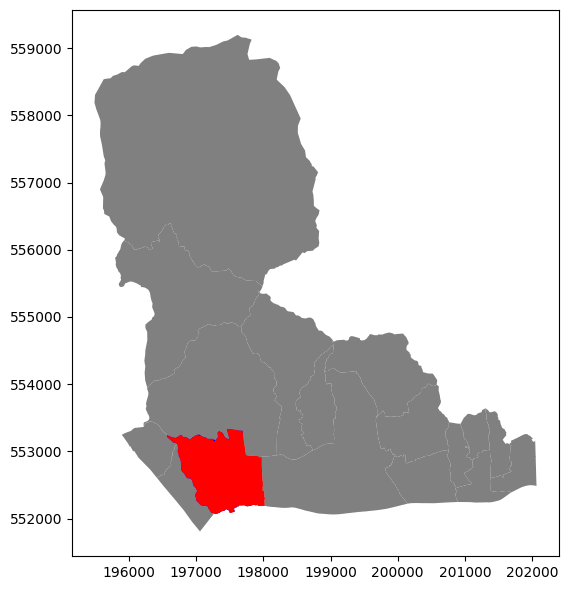

In [32]:
fig, ax = plt.subplots(figsize=(6,6))


gdf = gpd.GeoDataFrame(base_tmp, geometry=base_tmp["geometry"])
gdf.plot(ax=ax, color="grey", label="included")

gdf = gpd.GeoDataFrame(bdong_tmp, geometry=bdong_tmp["geometry"])
gdf.plot(ax=ax, color="blue", label="included")

gdf = gpd.GeoDataFrame(hdong_tmp, geometry=hdong_tmp["geometry"])
gdf.plot(ax=ax, color="red", label="main")
fig.tight_layout()
# ax.set_title()

In [33]:
# save
import json

In [34]:
with open("./data/preproc_data/행정동_법정동_매퍼/by_intersection_n_pct/bdong2hdong_dict.json", "w") as f:
    json.dump(bdong2hdong_dict, f, indent=4, ensure_ascii=False)

with open("./data/preproc_data/행정동_법정동_매퍼/by_intersection_n_pct/hdong2bdong_dict.json", "w") as f:
    json.dump(hdong2bdong_dict, f, indent=4, ensure_ascii=False)

In [35]:
bdong2hdong_df.reset_index(drop=True).to_csv(
    "./data/preproc_data/행정동_법정동_매퍼/by_intersection_n_pct/bdong2hdong_df.csv", index=False
)
hdong2bdong_df.reset_index(drop=True).to_csv(
    "./data/preproc_data/행정동_법정동_매퍼/by_intersection_n_pct/hdong2bdong_df.csv", index=False
)

In [36]:
bdong = bdong_shp_df.copy()
hdong = hdong_shp_df.copy()

In [37]:
bdong["total_name"] = bdong["rough_name"] + "_" + bdong["detail_name"]
bdong_code_name_dict = bdong.set_index("detail_code")["total_name"].to_dict()

In [38]:
hdong["total_name"] = hdong["rough_name"] + "_" + hdong["detail_name"]
hdong_code_name_dict = hdong.set_index("detail_code")["total_name"].to_dict()

In [39]:
with open("./data/preproc_data/행정동_법정동_매퍼/bdong_code_name_dict.json", "w") as f:
    json.dump(bdong_code_name_dict, f, indent=4, ensure_ascii=False)

with open("./data/preproc_data/행정동_법정동_매퍼/hdong_code_name_dict.json", "w") as f:
    json.dump(hdong_code_name_dict, f, indent=4, ensure_ascii=False)

In [40]:
bdong2hdong_df["bdong_name"] = bdong2hdong_df["bdong"].map(bdong_code_name_dict)
bdong2hdong_df["hdong_name"] = bdong2hdong_df["hdong"].map(hdong_code_name_dict)
hdong2bdong_df["hdong_name"] = hdong2bdong_df["hdong"].map(hdong_code_name_dict)
hdong2bdong_df["bdong_name"] = hdong2bdong_df["bdong"].map(bdong_code_name_dict)

In [41]:
display(hdong2bdong_df.sample(5))
display(bdong2hdong_df.sample(5))

,hdong,bdong,hdong_name,bdong_name
371,37530330,47750330,경상북도_청송군_현동면,경상북도_청송군_현동면
3059,31200350,41480350,경기도_파주시_광탄면,경기도_파주시_광탄면
161,39020590,50130102,제주특별자치도_서귀포시_대륜동,제주특별자치도_서귀포시_법환동
1250,38050620,48220101,경상남도_통영시_도천동,경상남도_통영시_도천동
236,11150540,11470102,서울특별시_양천구_목4동,서울특별시_양천구_목동


,bdong,hdong,bdong_name,hdong_name
4095,41135105,31023590,경기도_성남시_서현동,경기도_성남시_서현2동
1976,46110115,36010600,전라남도_목포시_상락동1가,전라남도_목포시_목원동
4109,41150101,31030520,경기도_의정부시_의정부동,경기도_의정부시_의정부2동
4779,50110125,39010680,제주특별자치도_제주시_이호일동,제주특별자치도_제주시_이호동
1763,11710101,11240780,서울특별시_송파구_잠실동,서울특별시_송파구_잠실7동
